In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#!git clone https://github.com/zzh8829/yolov3-tf2

In [13]:
%cd /content/drive/My Drive/yolov3-tf2
!ls

/content/drive/My Drive/yolov3-tf2
checkpoints	 data		  logs			setup.py
colab_gpu.ipynb  detect.py	  output.jpg		tools
conda-cpu.yml	 detect_video.py  README.md		train.py
conda-gpu.yml	 docs		  requirements-gpu.txt	yolov3_tf2
convert.py	 LICENSE	  requirements.txt	yolov3_tf2.egg-info


In [14]:
!sudo pip3 install -r requirements-gpu.txt &

Obtaining file:///content/drive/My%20Drive/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
  Found existing installation: yolov3-tf2 0.1
    Can't uninstall 'yolov3-tf2'. No files were found to uninstall.
  Running setup.py develop for yolov3-tf2


In [ ]:
#%tensorflow_version 2.x

#import tensorflow as tf
#tf.__version__

'2.2.0'

In [16]:
!python tools/visualize_dataset.py --dataset ./data/voc2012_train.tfrecord --classes=./data/voc2012.names --yolo_max_boxes 300

2020-07-25 23:37:09.833521: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-07-25 23:37:09.833624: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-07-25 23:37:09.833644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0725 23:37:10.667369 140186381465472 visualize_dataset.py:22] classes loaded
2020-07-25 23:37:10.668712: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library lib

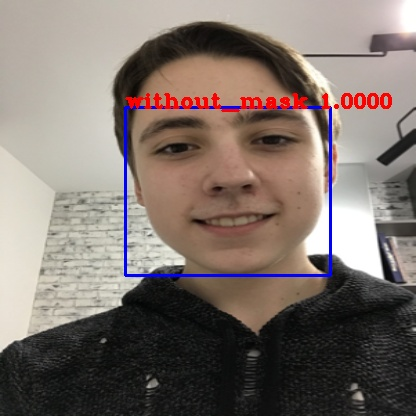

In [17]:
#visualizando el resultado
from IPython.display import Image

Image(filename='./output.jpg')

Train

In [18]:
from absl import app, flags, logging
from absl.flags import FLAGS
from datetime import datetime

import tensorflow as tf
import numpy as np
import cv2


from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny, YoloLoss,
    yolo_anchors, yolo_anchor_masks,
    yolo_tiny_anchors, yolo_tiny_anchor_masks
)
from yolov3_tf2.utils import freeze_all
import yolov3_tf2.dataset as dataset

In [19]:
tiny = False
dataset_ = './data/voc2012_train.tfrecord'
val_dataset = './data/voc2012_val.tfrecord'
classes = './data/voc2012.names' 
size = 416
num_classes = 3
mode = 'fit'
transfer = 'darknet'
batch_size = 32
epochs = 500
weights = './checkpoints/yolov3.tf'
weights_num_classes=80
learning_rate = 1e-4
yolo_max_boxes = 300

In [20]:
#####################################################
#Augmenting playing with contrast only
'''train_dataset = train_dataset.map(
    lambda image,label : (tf.image.convert_image_dtype(image, tf.float32),label)
).cache().map(
    lambda image,label: (tf.image.random_contrast(image,lower=0.7, upper=0.9),label)
).map(
    lambda image,label: (tf.image.random_brightness(image,0.05),label)
).repeat(2).shuffle(buffer_size=512)
#.map(
  #  lambda image,label: (tf.image.random_saturation(image,0.6,0.9),label)
#)'''


'train_dataset = train_dataset.map(\n    lambda image,label : (tf.image.convert_image_dtype(image, tf.float32),label)\n).cache().map(\n    lambda image,label: (tf.image.random_contrast(image,lower=0.7, upper=0.9),label)\n).map(\n    lambda image,label: (tf.image.random_brightness(image,0.05),label)\n).repeat(2).shuffle(buffer_size=512)\n#.map(\n  #  lambda image,label: (tf.image.random_saturation(image,0.6,0.9),label)\n#)'

In [21]:
'''physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
  tf.config.experimental.set_memory_growth(physical_device, True)
'''
if tiny:
  model = YoloV3Tiny(size, training=True,
                      classes=num_classes)
  anchors = yolo_tiny_anchors
  anchor_masks = yolo_tiny_anchor_masks
else:
  model = YoloV3(size, training=True, classes=num_classes)
  anchors = yolo_anchors
  anchor_masks = yolo_anchor_masks

In [22]:
train_dataset = dataset.load_fake_dataset()
if dataset:
  train_dataset = dataset.load_tfrecord_dataset(
      dataset_, classes, size)
  
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)


train_dataset = train_dataset.map(lambda x, y: (
  dataset.transform_images(x, size),
  dataset.transform_targets(y, anchors, anchor_masks, size)))
train_dataset = train_dataset.prefetch(
  buffer_size=tf.data.experimental.AUTOTUNE)

#val_dataset = dataset.load_fake_dataset()
val_dataset = dataset.load_tfrecord_dataset(val_dataset, classes, size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
  dataset.transform_images(x, size),
  dataset.transform_targets(y, anchors, anchor_masks, size)))


In [23]:
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            multiple             40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, 13, 13, 512)  11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, 26, 26, 256)  2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

In [24]:
# Configure the model for transfer learning
if transfer == 'none':
    pass  # Nothing to do
elif transfer in ['darknet', 'no_output']:
    # Darknet transfer is a special case that works
    # with incompatible number of classes

    # reset top layers
    if tiny:
        model_pretrained = YoloV3Tiny(
            size, training=True, classes=weights_num_classes or num_classes)
    else:
        model_pretrained = YoloV3(
            size, training=True, classes=weights_num_classes or num_classes)
    
    model_pretrained.load_weights(weights).expect_partial()

    if transfer == 'darknet':
        model.get_layer('yolo_darknet').set_weights(
            model_pretrained.get_layer('yolo_darknet').get_weights())
        freeze_all(model.get_layer('yolo_darknet'))

    elif transfer == 'no_output':
        for l in model.layers:
            if not l.name.startswith('yolo_output'):
                l.set_weights(model_pretrained.get_layer(
                    l.name).get_weights())
                freeze_all(l)

else:
    # All other transfer require matching classes
    model.load_weights(weights)
    if transfer == 'fine_tune':
        # freeze darknet and fine tune other layers
        darknet = model.get_layer('yolo_darknet')
        freeze_all(darknet)
    elif transfer == 'frozen':
        # freeze everything
        freeze_all(model)

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
loss = [YoloLoss(anchors[mask], classes=num_classes)
        for mask in anchor_masks]

if mode == 'eager_tf':
    # Eager mode is great for debugging
    # Non eager graph mode is recommended for real training
    avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
    avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

    for epoch in range(1, epochs + 1):
        for batch, (images, labels) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                outputs = model(images, training=True)
                regularization_loss = tf.reduce_sum(model.losses)
                pred_loss = []
                for output, label, loss_fn in zip(outputs, labels, loss):
                    pred_loss.append(loss_fn(label, output))
                total_loss = tf.reduce_sum(pred_loss) + regularization_loss

            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(
                zip(grads, model.trainable_variables))

            logging.info("{}_train_{}, {}, {}".format(
                epoch, batch, total_loss.numpy(),
                list(map(lambda x: np.sum(x.numpy()), pred_loss))))
            avg_loss.update_state(total_loss)

        for batch, (images, labels) in enumerate(val_dataset):
            outputs = model(images)
            regularization_loss = tf.reduce_sum(model.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss

            logging.info("{}_val_{}, {}, {}".format(
                epoch, batch, total_loss.numpy(),
                list(map(lambda x: np.sum(x.numpy()), pred_loss))))
            avg_val_loss.update_state(total_loss)

        logging.info("{}, train: {}, val: {}".format(
            epoch,
            avg_loss.result().numpy(),
            avg_val_loss.result().numpy()))

        avg_loss.reset_states()
        avg_val_loss.reset_states()
        model.save_weights(
            'checkpoints/yolov3_train_{}.tf'.format(epoch))
else:
    model.compile(optimizer=optimizer, loss=loss,
                    run_eagerly=(mode == 'eager_fit'))

    logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        ReduceLROnPlateau(verbose=1),
        EarlyStopping(patience=30, verbose=1,restore_best_weights=True),
        ModelCheckpoint('checkpoints/yolov3_train_{epoch}.tf',
                        verbose=1, save_weights_only=True,
                        period=25,
                        monitor="val_loss",
        ),
        TensorBoard(log_dir=logdir)
    ]
    history = model.fit(train_dataset,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=val_dataset
                        )


Epoch 1/500
66/66 [==============================] - 168s 3s/step - loss: 889.6190 - yolo_output_0_loss: 28.7997 - yolo_output_1_loss: 169.0512 - yolo_output_2_loss: 681.1098 - val_loss: 3658.0387 - val_yolo_output_0_loss: 73.6916 - val_yolo_output_1_loss: 452.0160 - val_yolo_output_2_loss: 3121.7339
Epoch 2/500
66/66 [==============================] - 155s 2s/step - loss: 54.3115 - yolo_output_0_loss: 2.3713 - yolo_output_1_loss: 6.6376 - yolo_output_2_loss: 34.7040 - val_loss: 681.8034 - val_yolo_output_0_loss: 33.2700 - val_yolo_output_1_loss: 127.4907 - val_yolo_output_2_loss: 510.4452
Epoch 3/500
66/66 [==============================] - 157s 2s/step - loss: 37.5764 - yolo_output_0_loss: 1.4804 - yolo_output_1_loss: 4.9804 - yolo_output_2_loss: 20.5179 - val_loss: 440.4302 - val_yolo_output_0_loss: 8.9042 - val_yolo_output_1_loss: 18.7577 - val_yolo_output_2_loss: 402.1712
Epoch 4/500
66/66 [==============================] - 159s 2s/step - loss: 30.4426 - yolo_output_0_loss: 1.1093

In [25]:
import tensorflow as tf
tf.__version__
%reload_ext tensorboard
%tensorboard --logdir logs/scalars/

Reusing TensorBoard on port 6006 (pid 843), started 7:12:06 ago. (Use '!kill 843' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
#Probando con mi imagen
!python detect.py \
	--classes ./data/voc2012.names \
	--num_classes 3 \
	--weights ./checkpoints/yolov3_train_75.tf \
	--image ./data/20200707_162112.jpg \
  --yolo_max_boxes 300 \
  --yolo_iou_threshold 0.05\
  --yolo_score_threshold 0.05


2020-07-19 02:42:14.971385: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-07-19 02:42:14.971517: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-07-19 02:42:14.971544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-07-19 02:42:15.984624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-19 02:42:16.002549: I tensorflow/stream_executor/cuda/cuda_g

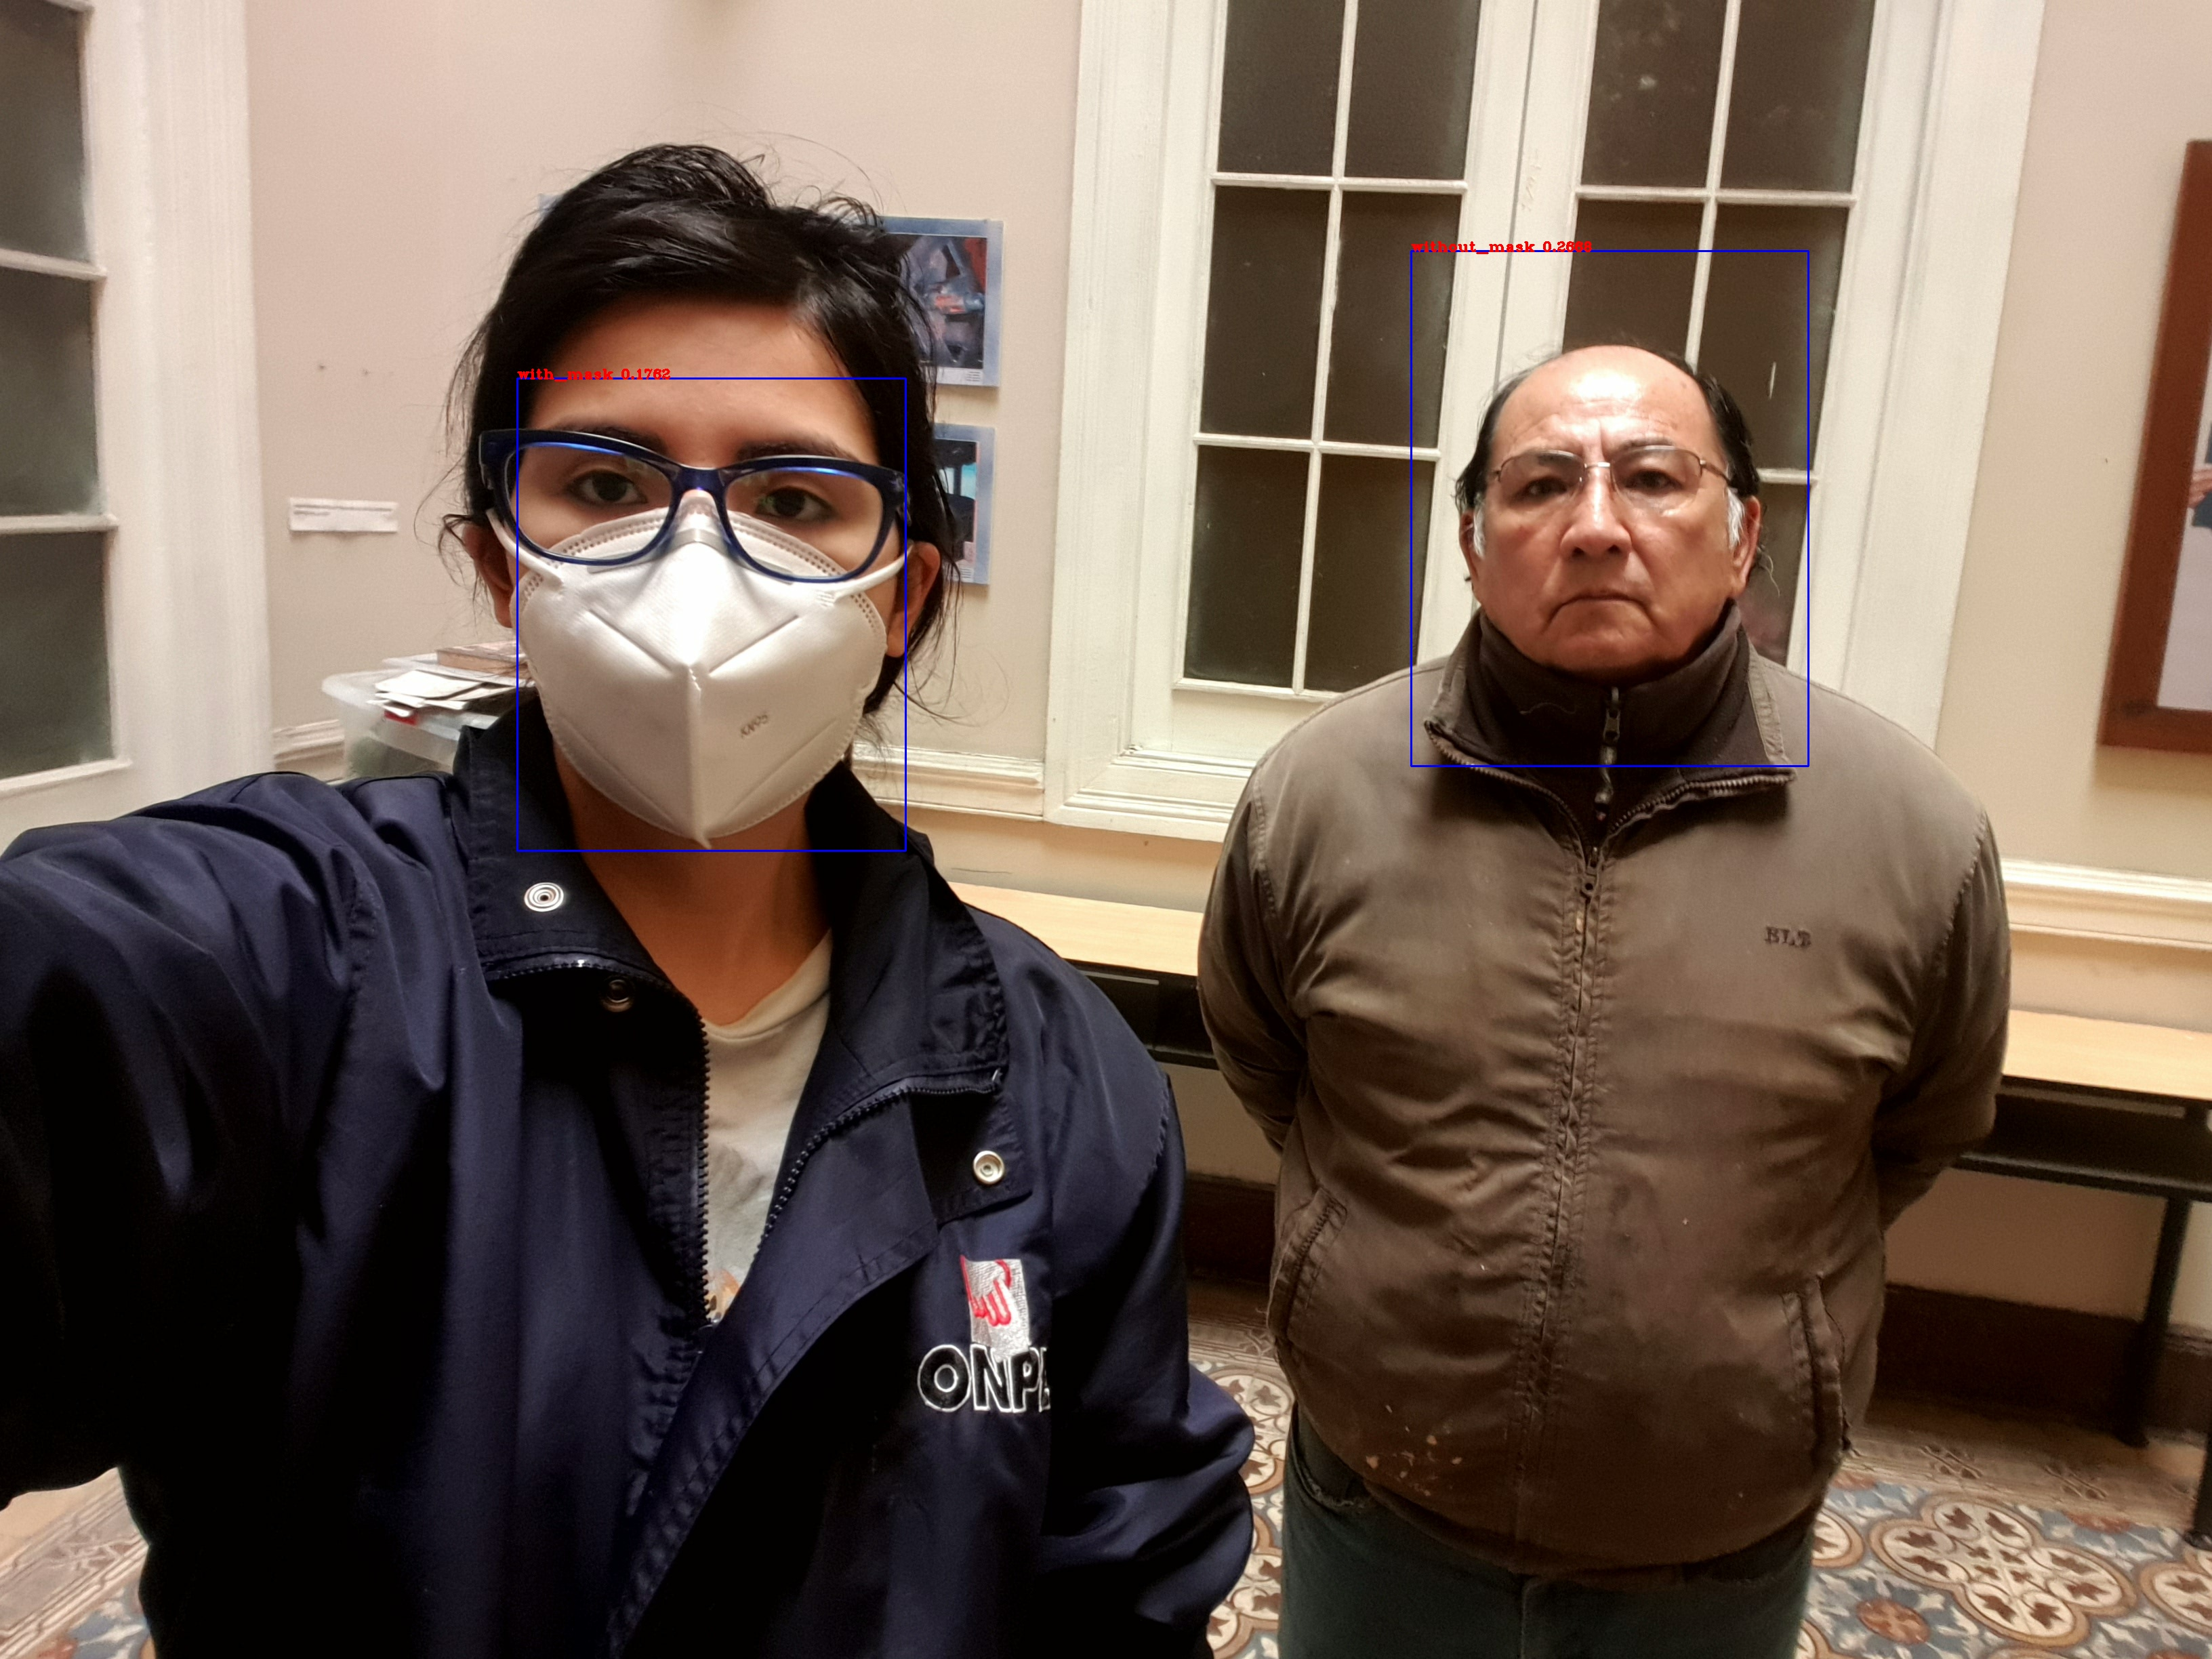

In [ ]:
#visualizando el resultado
from IPython.display import Image

Image(filename='./output.jpg')

In [ ]:
def draw_outputs_mine(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        class_name = class_names[int(classes[i])]
        
        #without mask RED
        color =  (0, 0, 255)
        if class_name == 'with_mask': #GREEN
          color = (0,255,0)
        if class_name == "mask_weared_incorrect": #RED
          color = (255,0,0)

        
        img = cv2.rectangle(img, x1y1, x2y2, color, 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_name, objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, color, 2)
    return img

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

DuplicateFlagError: ignored

In [ ]:
flags.DEFINE_string('video','./data/2020-07-07-185827.mp4' ,'path to video file or number for webcam)')
flags.DEFINE_string('output_format', 'XVID', 'codec used in VideoWriter when saving video to file')
FLAGS.output = '/content/drive/My Drive/yolov3-tf2/data/temp.avi'

DuplicateFlagError: ignored

In [ ]:
#LOAD WEIGHTS AND CREATE MODEL
FLAGS.num_classes = 3
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_75.tf'
FLAGS.tiny = False
FLAGS.yolo_max_boxes = 300  ##########################################

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

I0719 03:27:05.520886 140709242193792 <ipython-input-31-d47a98fb4fae>:18] weights loaded
I0719 03:27:05.530963 140709242193792 <ipython-input-31-d47a98fb4fae>:21] classes loaded


In [ ]:
#flags.DEFINE_string('output', './data/', 'path to output video')

#FLAGS.video = './data/20200707_161101_2.mp4' #calle 1000
FLAGS.video = './data/20200707_161331.mp4'#calle otro
#FLAGS.video = './data/2020-07-07-182247.mp4' #yo y mi papa 900
#FLAGS.video = './data/2020-07-12-213554.mp4' #yo solita sin mascara 650
#FLAGS.video = './data/2020-07-12-214002.mp4' #yo solita con mascara 350
#FLAGS.video = './data/20200712_221047.mp4' #yo con y sin mascara girando 900
#FLAGS.video = './data/2020-07-07-181233.mp4' #yo con y sin mascara parada 1500
#FLAGS.video = './data/2020-06-30-164808.mp4' #yo sin mascara bailando 200

FLAGS.output_format = 'XVID'
FLAGS.size = 416
FLAGS.output = '/content/drive/My Drive/yolov3-tf2/data/temp_ale_calle_5.avi'

times = []
vid = cv2.VideoCapture(FLAGS.video)
out = None

width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(vid.get(cv2.CAP_PROP_FPS))
codec = cv2.VideoWriter_fourcc(*FLAGS.output_format)
out = cv2.VideoWriter(FLAGS.output, codec, fps, (width, height))

cont = 0
while True:
  cont = cont + 1
  if (cont%50)==0:
    print(cont)
  _, img = vid.read()

  if img is None:
      logging.warning("Empty Frame")
      time.sleep(0.1)
      break

  img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_in = tf.expand_dims(img_in, 0)
  img_in = transform_images(img_in, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo.predict(img_in)
  t2 = time.time()
  times.append(t2-t1)
  times = times[-20:]

  img = draw_outputs_mine(img, (boxes, scores, classes, nums), class_names)
  img = cv2.putText(img, " Cont:{} ,Time: {:.2f}ms".format(cont,sum(times)/len(times)*1000), (0, 30),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
  if FLAGS.output:
      out.write(img)
  #display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=400))
  #cv2.imshow('output', img)
  if cv2.waitKey(1) == ord('q'):
      break
out.release();
cv2.destroyAllWindows()



50
100
150
200
250
300
350
400
450
500


W0719 03:43:57.261096 140709242193792 <ipython-input-38-4f0eaaf1fa60>:34] Empty Frame


Detectar en imagenes de test

In [ ]:
path_test =  'data/voc2012_raw/VOCdevkit/VOC2012/ImageSets/Main/'
test = open(path_test + 'test.txt',"r")
Lines = test.readlines() 
names_test = []
for line in Lines: 
    name = line.split()[0]
    #name = name + '.png'
    names_test.append(name)


path_val =  'data/voc2012_raw/VOCdevkit/VOC2012/ImageSets/Main/'
val = open(path_val + 'val.txt',"r")
Lines = val.readlines() 
names_val = []
for line in Lines: 
    name = line.split()[0]
    #name = name + '.png'
    names_val.append(name)

path_train =  'data/voc2012_raw/VOCdevkit/VOC2012/ImageSets/Main/'
train = open(path_val + 'train.txt',"r")
Lines = train.readlines() 
names_train = []
for line in Lines: 
    name = line.split()[0]
    #name = name + '.png'
    names_train.append(name)

In [ ]:
len(names_val)

790

In [ ]:
len(names_test)

24

In [ ]:
from IPython.display import Image, display
from yolov3_tf2.utils import draw_outputs

import os


#LOAD WEIGHTS AND CREATE MODEL
FLAGS.num_classes = 3
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_75.tf'
FLAGS.tiny = True

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2
FLAGS.yolo_max_boxes = 300


image_path = '/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/'
drawings_path = '/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/'
names = names_val


for i, filename in enumerate(names):

  if (i%50)==0:
    print("Image ",i)
    print(drawings_path + FLAGS.image)

  FLAGS.image = filename + '.png'
  #name = filename.split('.')[0]
  try:  
    img_raw = tf.image.decode_image(
        open(image_path + FLAGS.image, 'rb').read(), channels=3)
  except:
    try:
      FLAGS.image = filename + '.jpg'
      img_raw = tf.image.decode_image(
        open(image_path + FLAGS.image, 'rb').read(), channels=3)
    except:
      try:
        FLAGS.image = filename + '.jpeg'
        img_raw = tf.image.decode_image(
        open(image_path + FLAGS.image, 'rb').read(), channels=3)
      except:
        print("wrong image")
        continue

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  '''logging.info('time: {}'.format(t2 - t1))
  logging.info('detections:')
  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))
'''
  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs_mine(img, (boxes, scores, classes, nums), class_names)
  #encoded = cv2.imencode('.png', img)
  #annotated = Image(data=bytes(encoded[1]), width=400)
  #display(annotated)
    
  #Save images displaying annotations of groundtruth
  
  cv2.imwrite(drawings_path + FLAGS.image, img) 
  



Image  0
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss837.png
Image  50
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss417.png
Image  100
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss667.png
Image  150
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss355.png
Image  200
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss338.png
Image  250
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss820.png
Image  300
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss728.png
Image  350
/content/drive/My Drive/yolov3-tf2/data/voc2012_raw/VOCdevkit/VOC2012/Drawings/valnotinyfocal/maksssksksss684.png
Ima